In [2]:
import os
import json
import numpy as np
import pandas as pd
import soundfile as sf

from HNA.modules.utils import (
    load_data,
    align_by_first_triggers,
    find_last_high_indices,
    annotate_conditions,
    get_sync_seconds_for_subject,
    load_audio_for_subject,
)

In [4]:
import random
import pandas as pd

cond_names = ["MULTI", "AUD", "VIZ"]
conditions = {
    "02": ["MULTI", "AUD", "VIZ"],
    "03": ["MULTI", "VIZ", "AUD"],
    #   '04': ["AUD", "VIZ", "MULTI"],
}
json_path = "../data/audio_sync.json"

SAVEPATH = '../data/processed'

data_dir = r'G:\My Drive\COSMIC FUTURE GROUNDED PRESENT\THE SEA PROJECT\PILOT\Sea_Project_data'
data_dir = '../data'
merged_annotated_list = []
merged_by_subj = {}

for subj in sorted(conditions.keys()):
    print(f"Processing subject {subj}...")
    eeg_data = load_data(subj, 'eeg', data_dir=data_dir)
    physio_data = load_data(subj, 'physio', data_dir=data_dir)
    
    if eeg_data is None or physio_data is None:
        print(f"  Missing data for subj {subj}, skipping.")
        continue

    # align by first trigger, merge, annotate
    physio_aligned, eeg_aligned = align_by_first_triggers(physio_data, eeg_data)
    merged_data = pd.concat([physio_aligned, eeg_aligned], axis=1)
    condition_indices = find_last_high_indices(merged_data, threshold=2000)
    # Print unique conditions 
    cond_list = conditions.get(subj)
    if cond_list is None:
        print(f"  No condition ordering for subj {subj}, skipping.")
        continue

    try:
        merged_annotated = annotate_conditions(merged_data, condition_indices, cond_list)
        u = merged_annotated['condition_names'].unique()
        print(u)
        audio_sync_count = (merged_annotated['condition_names'] == 'AUDIO_SYNC').sum()
        print("Number of AUDIO_SYNC events:", int(audio_sync_count))
    except AssertionError as e:
        print(f"  Annotation failed for subj {subj}: {e}. Skipping.")
        continue

    merged_annotated_list.append(merged_annotated)
    merged_by_subj[subj] = merged_annotated

print(f"Done. Processed {len(merged_annotated_list)} subjects.")

Processing subject 02...
Physio first trigger index: 648, EEG first trigger index: 2046


C:\Users\skite\Documents\Github\HumanNatureAttunement\src\HNA\modules\utils.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'AUDIO_SYNC' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_data.at[idx, 'condition_names'] = 'AUDIO_SYNC'


[0 'AUDIO_SYNC' 'RS1_start' 'RS1_stop' 'MULTI_start' 'MULTI_stop'
 'AUD_start' 'AUD_stop' 'VIZ_start' 'VIZ_stop' 'RS2_start' 'RS2_stop']
Number of AUDIO_SYNC events: 2
Processing subject 03...
Physio first trigger index: 1024, EEG first trigger index: 1307
[0 'AUDIO_SYNC' 'RS1_start' 'RS1_stop' 'MULTI_start' 'MULTI_stop'
 'VIZ_start' 'VIZ_stop' 'AUD_start' 'AUD_stop' 'RS2_start' 'RS2_stop']
Number of AUDIO_SYNC events: 3
Done. Processed 2 subjects.


C:\Users\skite\Documents\Github\HumanNatureAttunement\src\HNA\modules\utils.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'AUDIO_SYNC' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_data.at[idx, 'condition_names'] = 'AUDIO_SYNC'


In [7]:
import json
subj = '02'
merged_annotated = merged_by_subj[subj]

# ---- 1) Read sync time from JSON ----
sync_seconds = get_sync_seconds_for_subject(json_path, subj)

# ---- 2) Load and trim audio from sync time onward; write a new WAV ----
audio, sr, in_wav_path = load_audio_for_subject(subj, data_dir)
start_sample = int(round(sync_seconds * sr))
if start_sample >= len(audio):
    raise ValueError(
        f"Sync time ({sync_seconds:.2f}s) exceeds audio length ({len(audio)/sr:.2f}s)."
    )

print('Cutting audio from sample', start_sample, 'onward')

def fmt_seconds(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    s = sec % 60
    return f"{h:d}:{m:02d}:{s:05.2f}" if h else f"{m:d}:{s:05.2f}"

sample_seconds = start_sample / sr
print("Start time (from sample):", fmt_seconds(sample_seconds), f"({sample_seconds:.2f} s)")
print("Sync time (from JSON):   ", fmt_seconds(sync_seconds),   f"({sync_seconds:.2f} s)")
audio_cut = audio[start_sample:]  # from sync time to end

# Build an output filename in the same folder
audio_folder = os.path.dirname(in_wav_path)
base = os.path.splitext(os.path.basename(in_wav_path))[0]
out_wav_path = os.path.join(audio_folder, f"{base}_cut.wav")

sf.write(out_wav_path, audio_cut, sr)
print(f"Audio written: {out_wav_path}")

# ---- 3) Trim merged_annotated to start at the last AUDIO_SYNC marker ----
ma = merged_annotated  # already computed for subj "02"
if "condition_names" not in ma.columns:
    raise KeyError("merged_annotated must contain a 'condition_names' column.")

mask = (ma["condition_names"] == "AUDIO_SYNC")
if not mask.any():
    raise ValueError("No 'AUDIO_SYNC' markers found in merged_annotated.")

last_sync_idx = np.flatnonzero(mask.to_numpy())[-1]
merged_annotated_cut = ma.iloc[last_sync_idx:].reset_index(drop=True)

print(f"Merged rows: {len(ma)} -> {len(merged_annotated_cut)} (cut at index {last_sync_idx})")

# (Optional) Save the trimmed DataFrame for bookkeeping
# derived_dir = os.path.join(data_dir, f"sub-{int(subj):02d}", "derived")
# os.makedirs(derived_dir, exist_ok=True)
# out_csv_path = os.path.join(derived_dir, "merged_annotated_cut.csv")
# merged_annotated_cut.to_csv(out_csv_path, index=False)
# print(f"Merged_annotated written: {out_csv_path}")


Cutting audio from sample 8908200 onward
Start time (from sample): 3:22.00 (202.00 s)
Sync time (from JSON):    3:22.00 (202.00 s)
Audio written: ../data\sub-02\audio\TASCAM_1104S12_cut.wav
Merged rows: 503522 -> 503199 (cut at index 323)


In [89]:
subj = '02'
audio_data = load_data(subj, 'audio', data_dir=data_dir)[0][:, 0]


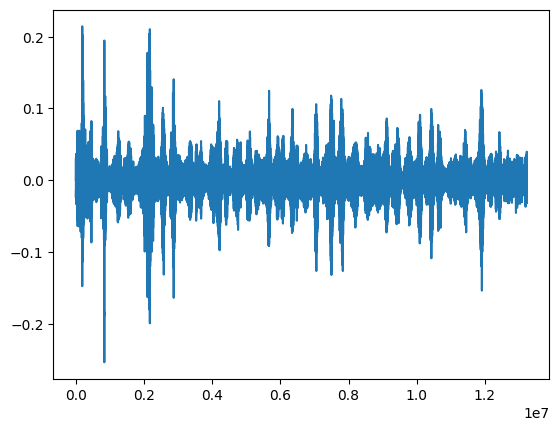

In [97]:
sfreq = 44100  # Hz
n_minutes = 5
plt.plot(audio_data[0:int(sfreq*n_minutes*60)])

In [143]:
len(merged_annotated)

503522

<Axes: >

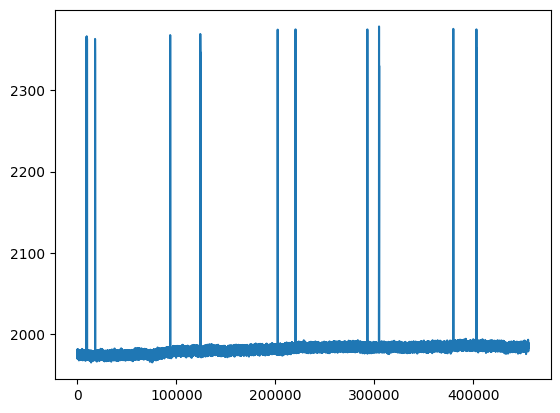

In [71]:
physio_data['condition_triggers'][:].plot()

# eeg_data['condition_triggers'][0:2000].plot()

In [5]:
merged_annotated

,ecg,respiration,physio_triggers,condition_triggers,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,...,EEG-ch25,EEG-ch26,EEG-ch27,EEG-ch28,EEG-ch29,EEG-ch30,EEG-ch31,EEG-ch32,eeg_triggers,condition_names
0,-20714.181987,53288.253021,1.0,1971.756425,10905.0,2.0,0.0,20494.282945,8713.677061,5227.120878,...,-3389.932503,14410.702223,8978.300132,11901.820480,-21189.995346,-12034.119847,-417.023473,6768.561215,1.0,0
1,-20709.812473,53277.620888,0.0,1973.230478,10905.0,2.0,0.0,20476.919642,8716.207942,5233.776608,...,-3379.589960,14404.496698,8966.387957,11884.688363,-21142.869857,-12017.024233,-71.692070,6747.584105,0.0,0
2,-20711.128591,53272.304821,0.0,1970.966753,10905.0,2.0,0.0,20461.052965,8702.847811,5218.080279,...,-3398.960934,14394.105485,8955.254514,11864.623830,-21188.133689,-12026.709720,-428.972151,6745.661609,0.0,0
3,-20705.390314,53277.308178,0.0,1972.546096,10905.0,2.0,0.0,20472.454097,8700.256092,5224.942860,...,-3409.011451,14395.249248,8960.973331,11881.086724,-21214.318572,-12036.492548,-529.075793,6749.616111,0.0,0
4,-20699.967905,53266.676044,0.0,1971.229977,10905.0,2.0,0.0,20458.716767,8697.019484,5228.349816,...,-3379.675134,14403.048742,8963.747566,11883.276910,-21149.610761,-12015.223414,-68.212108,6750.832881,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560331,-16398.207539,52447.063637,0.0,1972.546096,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
560332,-16373.885665,52457.070351,0.0,1971.387911,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
560333,-16385.730734,52516.797924,0.0,1968.966253,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
560334,-16399.471013,52456.757641,0.0,1971.861714,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
def get_condition_segments(df, conditions):
    """Return a dict of start/stop indices for each condition"""
    indices = {}
    for cond in conditions:
        # Find all indices labeled as this condition
        cond_idx = df.index[df['condition_names'] == cond].tolist()
        if cond_idx:
            # Assume one continuous segment per condition
            indices[cond] = (cond_idx[0])
        else:
            indices[cond] = None
    return indices

indices = get_condition_segments(merged_annotated_cut, merged_annotated_cut['condition_names'].unique())
indices

{'AUDIO_SYNC': 0,
 0: 1,
 'RS1_start': 2202,
 'RS1_stop': 86802,
 'MULTI_start': 117079,
 'MULTI_stop': 191161,
 'AUD_start': 215800,
 'AUD_stop': 294554,
 'VIZ_start': 312995,
 'VIZ_stop': 394328,
 'RS2_start': 417080,
 'RS2_stop': 496660}

# HRV FEATURES 

In [183]:
import neurokit2 as nk
import numpy as np

def rolling_hrv_neurokit(ecg_signal, fs, win_sec=60, overlap=0.9):
    win_samples = int(win_sec * fs)
    step_samples = int(win_samples * (1 - overlap))
    hrv_results = []
    win_starts = []

    for start in range(0, len(ecg_signal) - win_samples + 1, step_samples):
        segment = ecg_signal[start:start+win_samples]
        try:
            cleaned = nk.ecg_clean(segment, sampling_rate=fs)
            peaks, _ = nk.ecg_peaks(cleaned, sampling_rate=fs)
            hrv = nk.hrv(peaks, sampling_rate=fs, show=False)
            hrv_results.append(hrv.loc[0, 'HRV_CSI'])
        except Exception as e:
            hrv_results.append(np.nan)
        win_starts.append(start)
    return np.array(hrv_results), np.array(win_starts)

import neurokit2 as nk
import numpy as np
import pandas as pd

def rolling_hrv_neurokit_all(ecg_signal, fs, win_sec=60, overlap=0.9):
    win_samples = int(win_sec * fs)
    step_samples = int(win_samples * (1 - overlap))
    hrv_results = []
    win_starts = []

    for start in range(0, len(ecg_signal) - win_samples + 1, step_samples):
        segment = ecg_signal[start:start+win_samples]
        try:
            cleaned = nk.ecg_clean(segment, sampling_rate=fs)
            peaks, _ = nk.ecg_peaks(cleaned, sampling_rate=fs)
            hrv = nk.hrv(peaks, sampling_rate=fs, show=False)
            # Convert the first row of the DataFrame to dict
            hrv_results.append(hrv.iloc[0].to_dict())
        except Exception as e:
            # Fill with NaN for all features if failed
            if hrv_results:
                empty = {k: np.nan for k in hrv_results[0].keys()}
            else:
                empty = {}
            hrv_results.append(empty)
        win_starts.append(start)
    return hrv_results, np.array(win_starts)


fs = 256
condition_labels = ['RS1', 'MULTI', 'AUD', 'VIZ', 'RS2']

hrv_dict = {}
for cond in condition_labels:
    start_idx = indices.get(f"{cond}_start")
    stop_idx = indices.get(f"{cond}_stop")
    if start_idx is not None and stop_idx is not None:
        ecg = merged_annotated['ecg'].iloc[start_idx:stop_idx+1].values
        hrv_results, hrv_indices = rolling_hrv_neurokit_all(ecg, fs, win_sec=30, overlap=0.9)
        # Convert list of dicts to DataFrame for convenience
        hrv_features_df = pd.DataFrame(hrv_results)
        hrv_dict[cond] = {
            'features': hrv_features_df,
            'window_start_indices': hrv_indices + start_idx
        }


c:\Users\andre\miniconda3\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\andre\miniconda3\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\andre\miniconda3\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale`

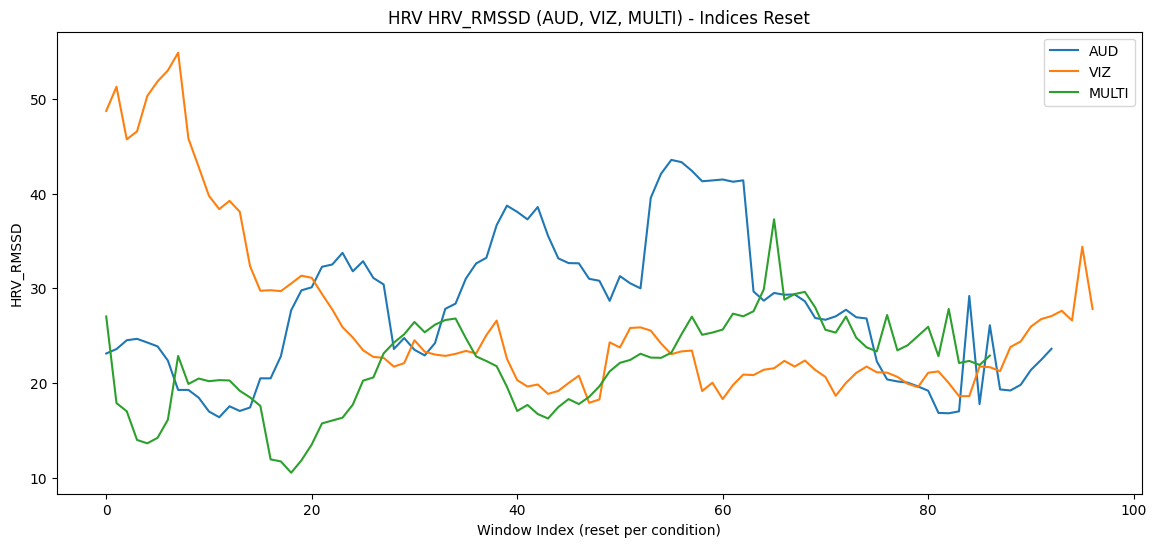

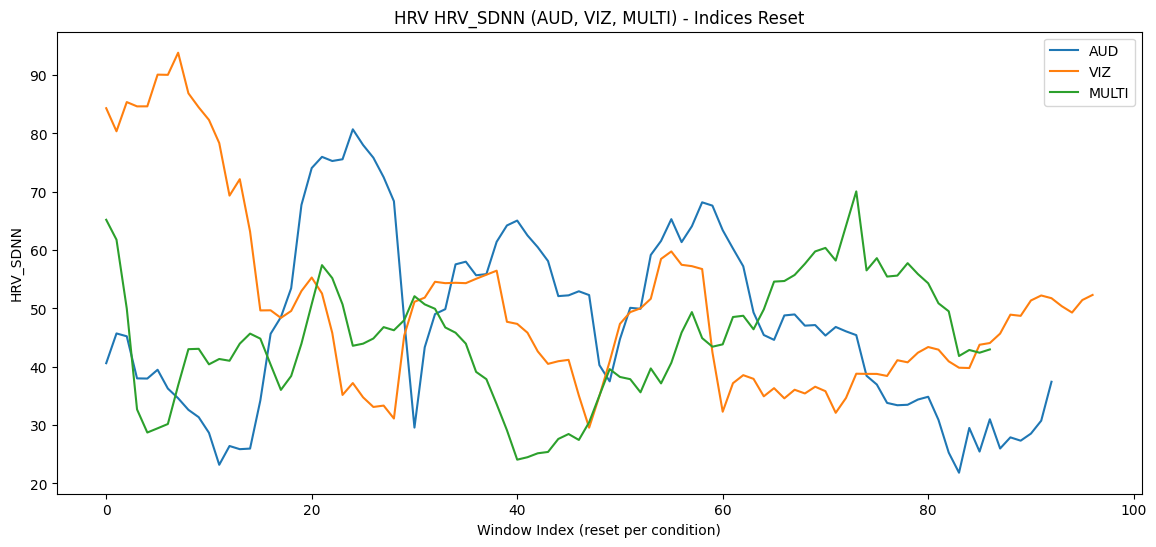

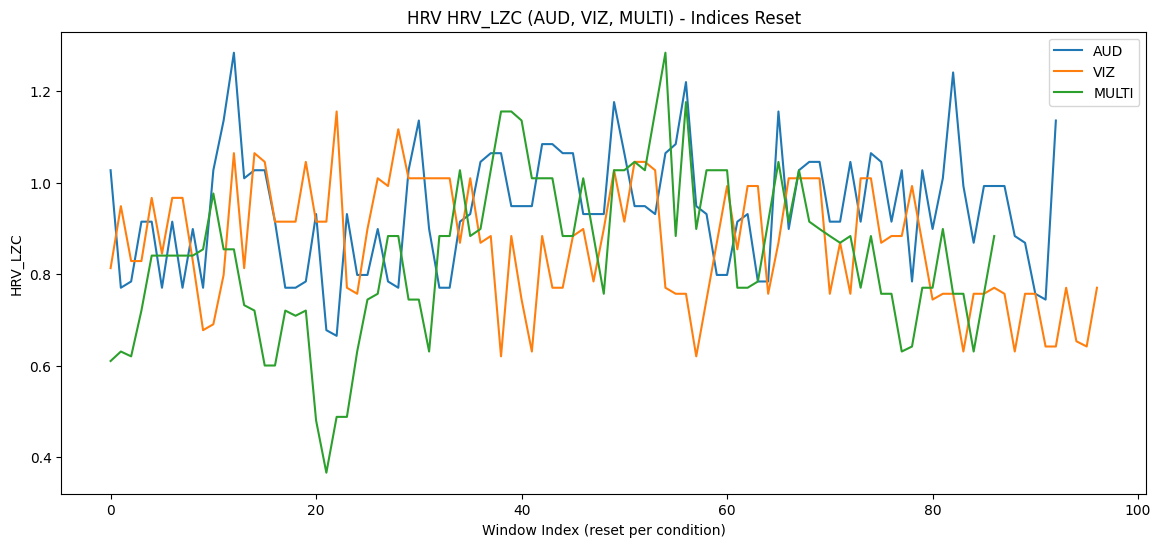

In [185]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hrv_feature(hrv_dict, feature_name, conditions=['AUD', 'VIZ', 'MULTI'], colors=None):
    """
    Plots a chosen HRV feature for each condition.
    Args:
        hrv_dict: dict as constructed above
        feature_name: string, e.g. 'HRV_RMSSD', 'HRV_SDNN', etc.
        conditions: list of conditions to plot
        colors: list of matplotlib color names or None for defaults
    """
    if colors is None:
        colors = ['tab:blue', 'tab:orange', 'tab:green']
    
    plt.figure(figsize=(14, 6))
    for cond, color in zip(conditions, colors):
        feats = hrv_dict[cond]['features']
        if feature_name in feats.columns:
            x = np.arange(len(feats))
            y = feats[feature_name].values
            plt.plot(x, y, label=cond, color=color)
        else:
            print(f"Feature '{feature_name}' not found for condition '{cond}'.")
    plt.title(f'HRV {feature_name} ({", ".join(conditions)}) - Indices Reset')
    plt.xlabel('Window Index (reset per condition)')
    plt.ylabel(feature_name)
    plt.legend()
    plt.show()

# Example usage:
plot_hrv_feature(hrv_dict, feature_name='HRV_RMSSD')
plot_hrv_feature(hrv_dict, feature_name='HRV_SDNN')
plot_hrv_feature(hrv_dict, feature_name='HRV_LZC')


In [149]:
condition_indices
merged_annotated['condition_names'][294875:294879]  # Example to check specific indices

294875           0
294876           0
294877    AUD_stop
294878           0
Name: condition_names, dtype: object

In [148]:
condition_indices

[151,
 323,
 2525,
 87125,
 117402,
 191484,
 216123,
 294877,
 313318,
 394651,
 417403,
 496983]

In [ ]:
merged_data

,ecg,respiration,physio_triggers,condition_triggers,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,...,EEG-ch24,EEG-ch25,EEG-ch26,EEG-ch27,EEG-ch28,EEG-ch29,EEG-ch30,EEG-ch31,EEG-ch32,eeg_triggers
0,-20714.181987,53288.253021,1.0,1971.756425,10905.0,2.0,0.0,20494.282945,8713.677061,5227.120878,...,77290.816355,-3389.932503,14410.702223,8978.300132,11901.820480,-21189.995346,-12034.119847,-417.023473,6768.561215,1.0
1,-20709.812473,53277.620888,0.0,1973.230478,10905.0,2.0,0.0,20476.919642,8716.207942,5233.776608,...,77325.031919,-3379.589960,14404.496698,8966.387957,11884.688363,-21142.869857,-12017.024233,-71.692070,6747.584105,0.0
2,-20711.128591,53272.304821,0.0,1970.966753,10905.0,2.0,0.0,20461.052965,8702.847811,5218.080279,...,77294.430161,-3398.960934,14394.105485,8955.254514,11864.623830,-21188.133689,-12026.709720,-428.972151,6745.661609,0.0
3,-20705.390314,53277.308178,0.0,1972.546096,10905.0,2.0,0.0,20472.454097,8700.256092,5224.942860,...,77294.186807,-3409.011451,14395.249248,8960.973331,11881.086724,-21214.318572,-12036.492548,-529.075793,6749.616111,0.0
4,-20699.967905,53266.676044,0.0,1971.229977,10905.0,2.0,0.0,20458.716767,8697.019484,5228.349816,...,77340.801254,-3379.675134,14403.048742,8963.747566,11883.276910,-21149.610761,-12015.223414,-68.212108,6750.832881,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560331,-16398.207539,52447.063637,0.0,1972.546096,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560332,-16373.885665,52457.070351,0.0,1971.387911,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560333,-16385.730734,52516.797924,0.0,1968.966253,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560334,-16399.471013,52456.757641,0.0,1971.861714,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np



[10046,
 10197,
 10388,
 29952,
 97975,
 129676,
 213560,
 257265,
 339177,
 375269,
 458760,
 485119,
 551694]

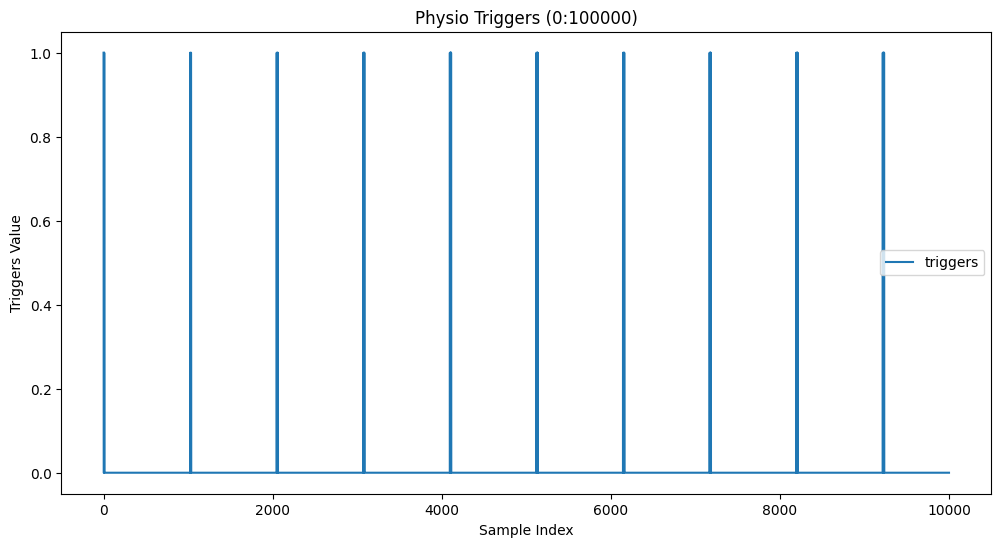

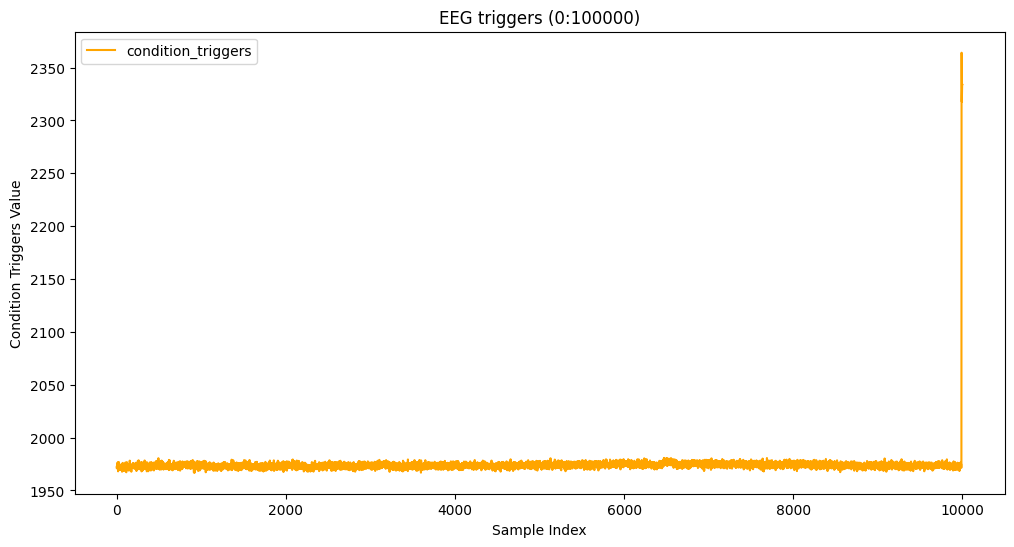

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(merged_data['physio_triggers'][0:10000], label='triggers')
plt.xlabel('Sample Index')
plt.ylabel('Triggers Value')
plt.title('Physio Triggers (0:100000)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data['condition_triggers'][0:10000], label='condition_triggers', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Condition Triggers Value')
plt.title('EEG triggers (0:100000)')
plt.legend()
plt.show()

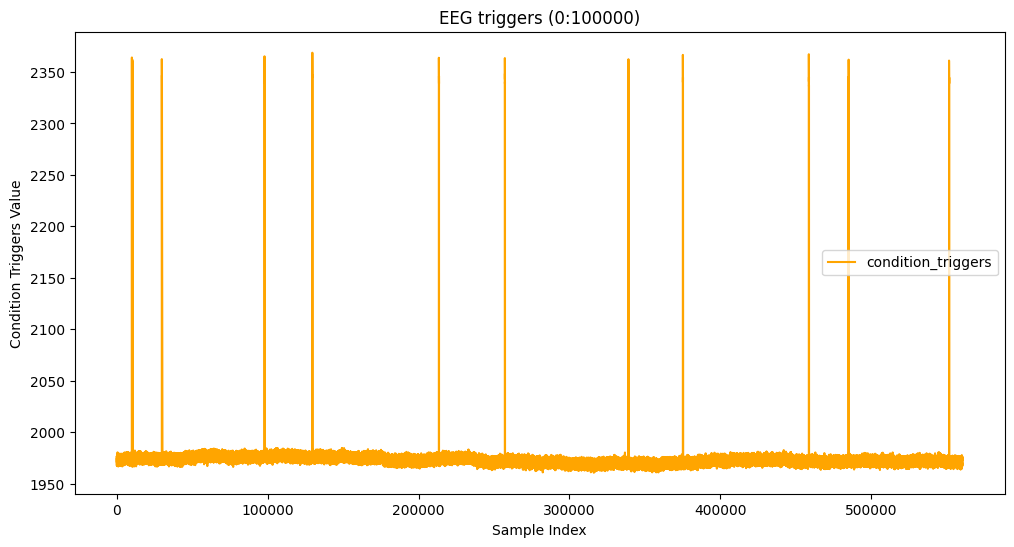

In [126]:
plt.figure(figsize=(12, 6))
plt.plot(merged_data['condition_triggers'][:], label='condition_triggers', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Condition Triggers Value')
plt.title('EEG triggers (0:100000)')
plt.legend()
plt.show()

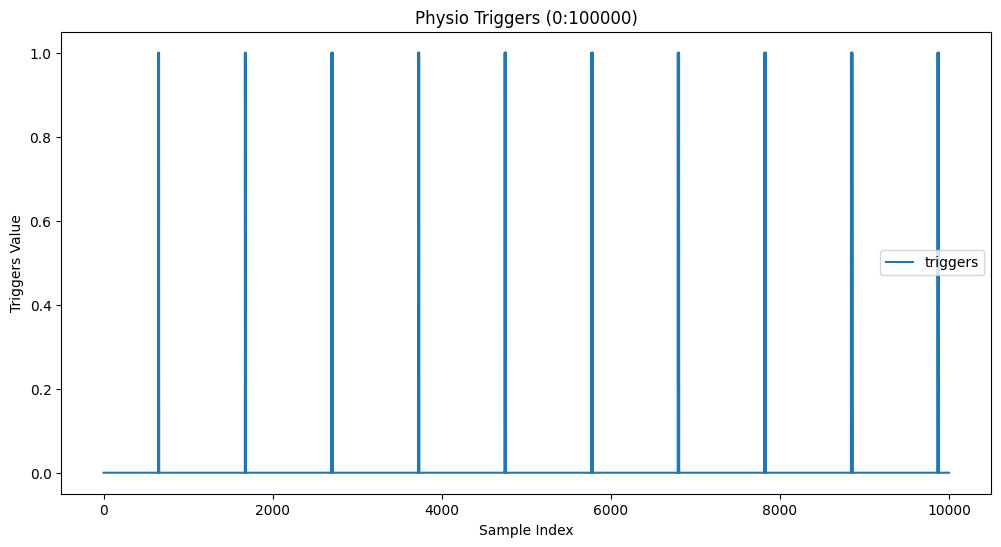

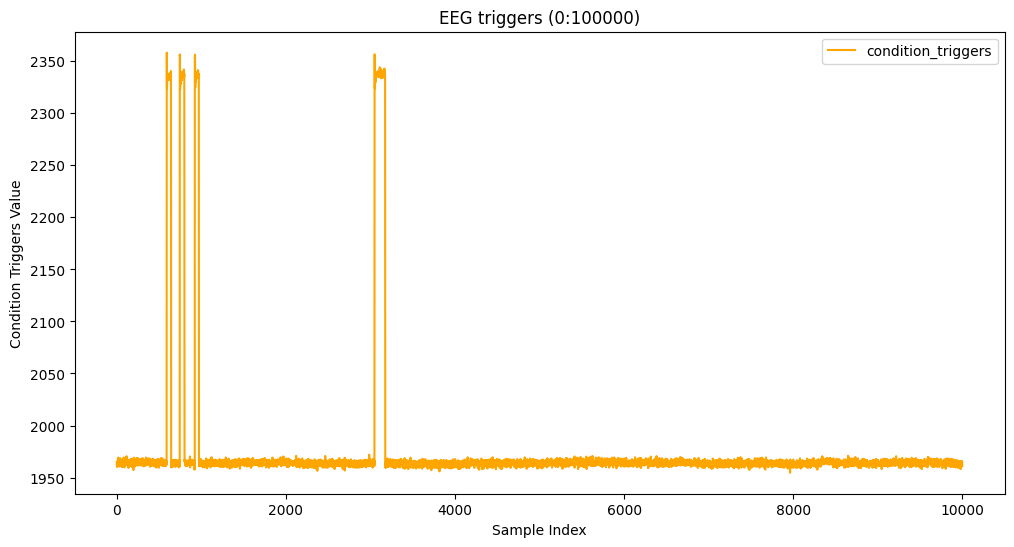

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(physio_data['triggers'][0:10000], label='triggers')
plt.xlabel('Sample Index')
plt.ylabel('Triggers Value')
plt.title('Physio Triggers (0:100000)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(physio_data['condition_triggers'][0:10000], label='condition_triggers', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Condition Triggers Value')
plt.title('EEG triggers (0:100000)')
plt.legend()
plt.show()

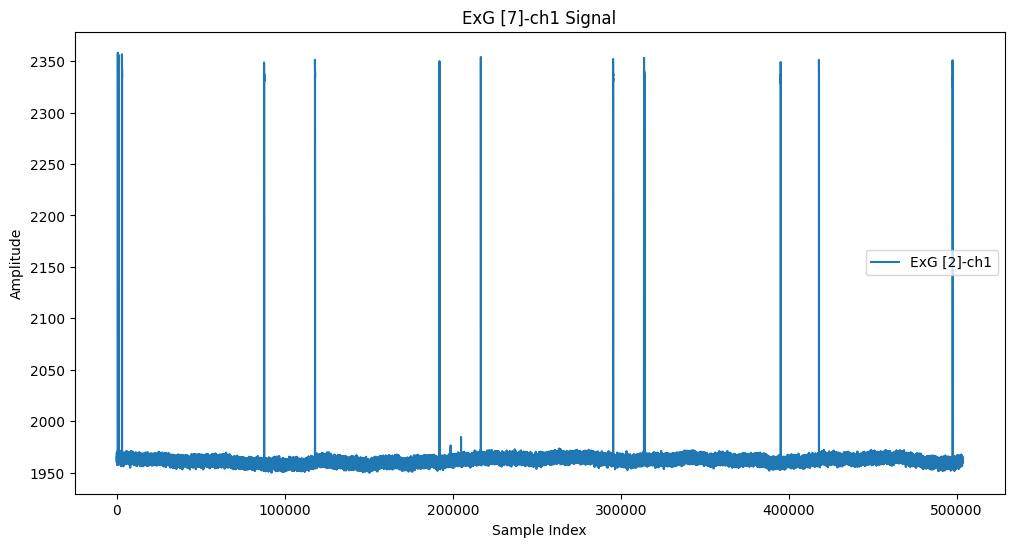

In [77]:
exg7 = physio_data['exg7'] if physio_data else None
# plot ExG [7]-ch1
if exg7 is not None:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(exg7['ExG [2]-ch1'][:], label='ExG [2]-ch1')
    plt.title('ExG [7]-ch1 Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

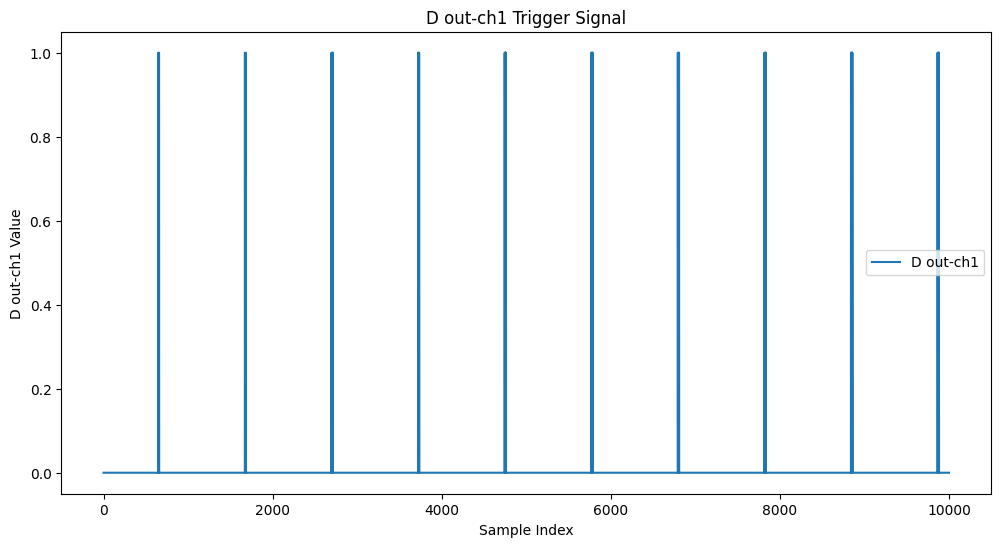

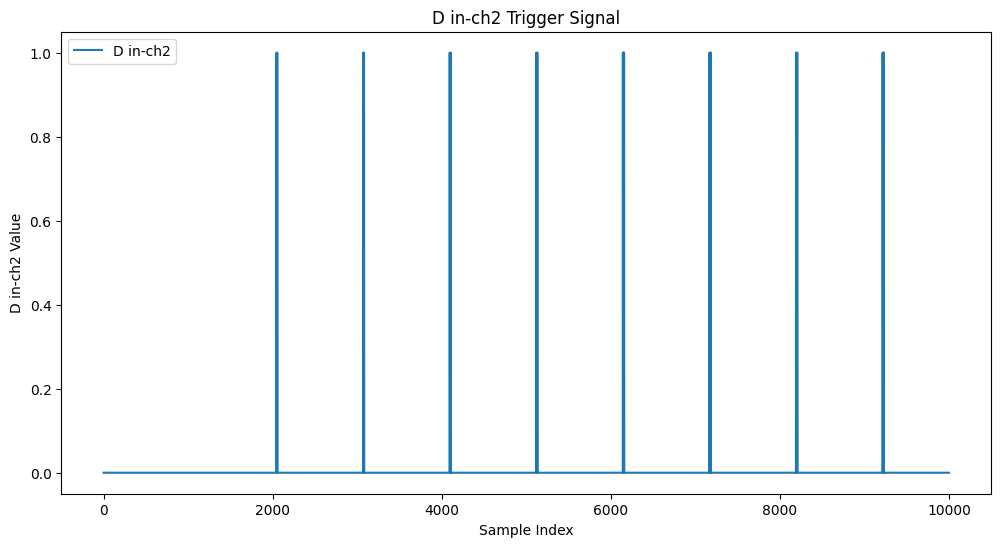

In [54]:
triggers = physio_data['triggers']
plt.figure(figsize=(12, 6))
plt.plot(triggers['triggers'][0:10000], label='D out-ch1')
plt.xlabel('Sample Index')
plt.ylabel('D out-ch1 Value')
plt.title('D out-ch1 Trigger Signal')
plt.legend()
plt.show()

triggers_eeg = eeg_data['triggers']
plt.figure(figsize=(12, 6))
plt.plot(triggers_eeg['triggers'][0:10000], label='D in-ch2')
plt.xlabel('Sample Index')  
plt.ylabel('D in-ch2 Value')
plt.title('D in-ch2 Trigger Signal')
plt.legend()
plt.show()

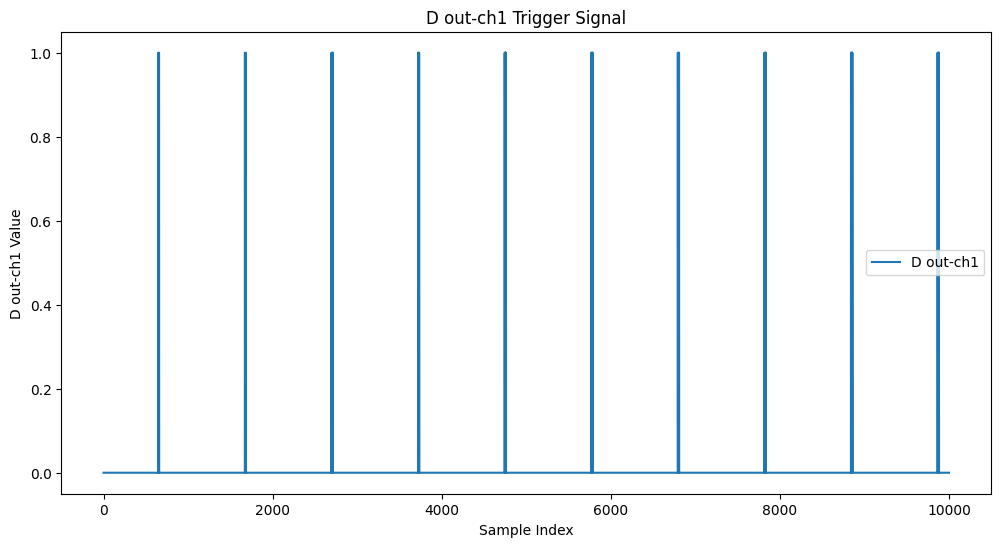

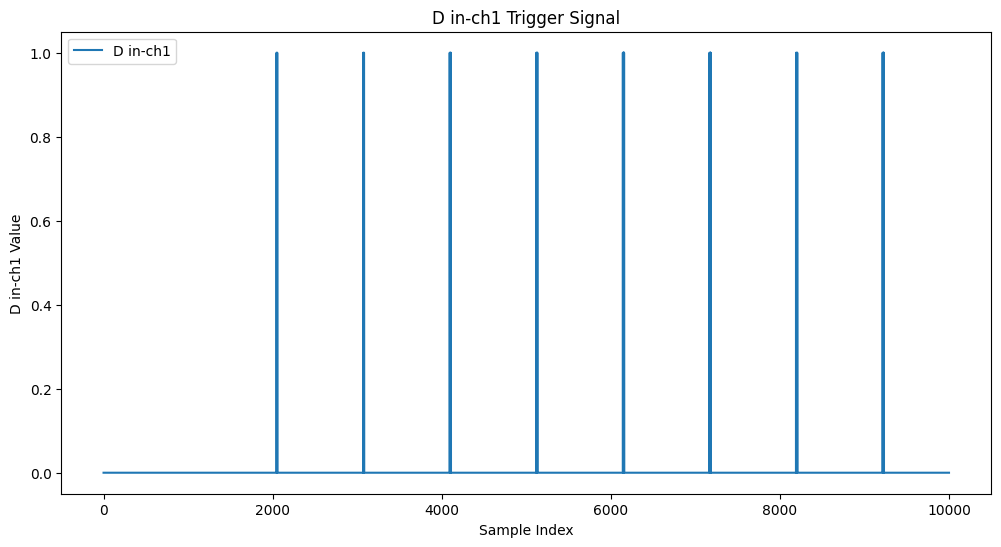

In [45]:
import matplotlib.pyplot as plt
triggers = physio_data['triggers']
plt.figure(figsize=(12, 6))
plt.plot(triggers['D out-ch1'][0:10000], label='D out-ch1')
plt.xlabel('Sample Index')
plt.ylabel('D out-ch1 Value')
plt.title('D out-ch1 Trigger Signal')
plt.legend()
plt.show()

# add plot of D in-ch1 from eeg_data
triggers_eeg = eeg_data['triggers']
plt.figure(figsize=(12, 6))
plt.plot(triggers_eeg['D in-ch2'][0:10000], label='D in-ch1')
plt.xlabel('Sample Index')  
plt.ylabel('D in-ch1 Value')
plt.title('D in-ch1 Trigger Signal')
plt.legend()
plt.show()

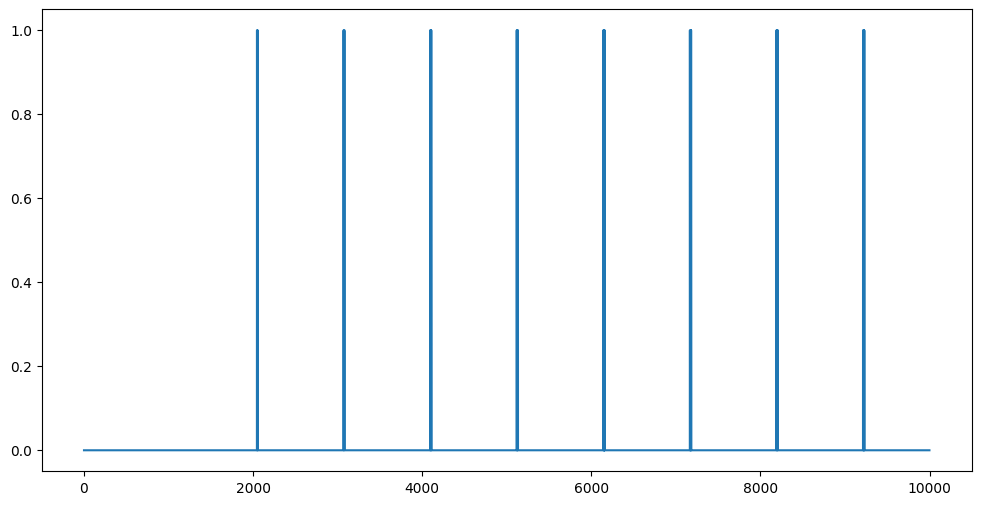

In [23]:
triggers = eeg_data['triggers']
# plot the D in-ch1 and ch2 and ch3 columns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
#plt.plot(triggers['D in-ch1'], label='D in - ch1')
plt.plot(triggers['D in-ch2'][0:10000], label='D in - ch2')
#plt.plot(triggers['D in-ch3'], label='D in - ch3')

In [5]:
#save merged_annotated to csv
merged_annotated.to_csv(f'../data/sub-{subj}_merged_annotated.csv', index=False)